<a href="https://colab.research.google.com/github/eunicebalicanta/stock-prediction-sentiment/blob/main/Stock_Trend_Prediction_Using_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Stock Market Trends with News Sentiment Analysis


# 1. Data Collection

In [12]:
# @title Install Libraries
# Install data manipulation libraries
!pip install pandas
!pip install numpy
!pip install datetime
!pip install json_normalize

# Install data visualization libraries
!pip install matplotlib
!pip install seaborn
!pip install plotly

# Install news and finance APIs
!pip install newsapi-python
!pip install --upgrade yfinance
!pip install mplfinance

# Install natural language processing libraries
!pip install nltk
!pip install vaderSentiment
!pip install textblob
!pip install regex

# Install other machine learning and statistics libraries
!pip install scikit-learn
!pip install scipy
!pip install tensorflow
!pip install keras
!pip install pmdarima
!pip install statsmodels

print("All libraries installed")

All libraries installed


In [25]:
# @title Import Libraries
# Import data manipulation libraries
import pandas as pd
import numpy as np
import datetime as dt
import requests
import json
import json_normalize

# Import data visualization libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as pgo
import seaborn as sns
import plotly as py
import plotly.express as px

# Import news and finance APIs
from newsapi import NewsApiClient
import yfinance as yf
import mplfinance as mpf

# Import natural language proccessing libraries
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import regex as re

# Import machine learning and statistics libraries
import sklearn as sk
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
import scipy as sp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# For Jupyer Notebook:
# %matplotlib inline

print("All libraries imported")

All libraries imported


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
# @title Retrieve Stock Information and Data
# Function for retrieving ticker symbol and company name
def get_company_name(symbol):
    try:
        ticker = yf.Ticker(symbol)
        info = ticker.info
        return info.get('longName', "Ticker name not found")
    except ValueError as ve:
        print(f"Value Error: {ve}")
        return None
    except Exception as e:
        print(f"Error: {e}")
        return None

# Input to enter ticker symbol
ticker_symbol = input("Enter the stock ticker symbol: ").strip().upper()

if not ticker_symbol:
    print("Ticker symbol cannot be empty.")
else:
    company_name = get_company_name(ticker_symbol)

if company_name:
    print(f"The company name for ticker symbol '{ticker_symbol}' is '{company_name}'")
else:
    print("Company symbol not found or there was an error.")

Enter the stock ticker symbol: META
The company name for ticker symbol 'META' is 'Meta Platforms, Inc.'


In [27]:
ticker = yf.Ticker(ticker_symbol)
print(f"{company_name} Information:")
ticker.info

Meta Platforms, Inc. Information:


{'address1': '1 Meta Way',
 'city': 'Menlo Park',
 'state': 'CA',
 'zip': '94025',
 'country': 'United States',
 'phone': '650 543 4800',
 'website': 'https://investor.fb.com',
 'industry': 'Internet Content & Information',
 'industryKey': 'internet-content-information',
 'industryDisp': 'Internet Content & Information',
 'sector': 'Communication Services',
 'sectorKey': 'communication-services',
 'sectorDisp': 'Communication Services',
 'longBusinessSummary': 'Meta Platforms, Inc. engages in the development of products that enable people to connect and share with friends and family through mobile devices, personal computers, virtual reality headsets, and wearables worldwide. It operates in two segments, Family of Apps and Reality Labs. The Family of Apps segment offers Facebook, which enables people to share, discuss, discover, and connect with interests; Instagram, a community for sharing photos, videos, and private messages, as well as feed, stories, reels, video, live, and shops; M

In [28]:
# Return date from today and 30 days ago
today = dt.date.today()
days_ago = today - dt.timedelta(days=30)
end = dt.date.today()
end = end.strftime('%Y-%m-%d')
start = days_ago.strftime('%Y-%m-%d')

print("Beginning and End Date for Information Retrieval:")
print("\n")
print(f"Date from 30 Days Ago: {start}")
print(f"Today's Date: {end}")

Beginning and End Date for Information Retrieval:


Date from 30 Days Ago: 2024-07-01
Today's Date: 2024-07-31


In [29]:
# Retrieve Open-High-Low-Close Data from Yahoo Finance
stock_df = ticker.history(period="1mo")
stock_df.reset_index(inplace=True)
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df.drop(['Dividends', 'Stock Splits', 'Volume'], axis=1, inplace=True)
stock_df.head()

,Date,Open,High,Low,Close
0,2024-07-01 00:00:00-04:00,504.950012,506.579987,493.170013,504.679993
1,2024-07-02 00:00:00-04:00,500.760010,510.500000,499.450012,509.500000
2,2024-07-03 00:00:00-04:00,506.369995,511.279999,506.019989,509.959991
3,2024-07-05 00:00:00-04:00,511.600006,540.869995,511.600006,539.909973
4,2024-07-08 00:00:00-04:00,542.349976,542.809998,526.650024,529.320007


In [30]:
# @title Retrieve Relevant News Data
# Query news API to fetch relevant articles to the company
news_api_key = 'f9397fe9af6d484cba729965088792f6'

url = f"https://newsapi.org/v2/everything?q={company_name}&from={start}&to={end}&sortBy=relevancy&apiKey={news_api_key}"
response = requests.get(url)
news_api_data = response.json()
news_api_data

{'status': 'ok',
 'totalResults': 801,
 'articles': [{'source': {'id': 'time', 'name': 'Time'},
   'author': 'Kurt Wagner / Bloomberg',
   'title': 'Meta to Let Some Instagram Users Create AI Chatbots as ‘Extension of Themselves’',
   'description': 'Meta is rolling out the feature, called AI Studio, to try to court creators and further integrate its artificial intelligence software into its most popular consumer products.',
   'url': 'https://time.com/7005238/meta-custom-ai-chatbot-instagram-professional-users-profile/',
   'urlToImage': 'https://api.time.com/wp-content/uploads/2024/07/instagram.jpg?quality=85&w=1024&h=628&crop=1',
   'publishedAt': '2024-07-30T02:40:00Z',
   'content': 'Instagram parent Meta Platforms Inc. will let users create their own AI-powered chatbots and add them to their profiles, an effort to court creators and further integrate the companys artificial inte… [+1534 chars]'},
  {'source': {'id': None, 'name': 'Yahoo Entertainment'},
   'author': 'Olivia Carvi

In [31]:
# Save the news data into a JSON file
with open('news_api_data.json', 'w') as file:
    json.dump(news_api_data, file)

print("Data saved to 'news_api_data.json'")

Data saved to 'news_api_data.json'


In [32]:
# Save news results into a dataframe
news_df = pd.json_normalize(news_api_data['articles'])
news_df.rename(columns={
    'source.id': 'source_id',
    'source.name': 'source_name',
    'publishedAt': 'date',
    'urlToImage': 'image_url'
}, inplace=True)
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')
news_df['date'] = news_df['date'].dt.date
news_df

,author,title,description,url,image_url,date,content,source_id,source_name
0,Kurt Wagner / Bloomberg,Meta to Let Some Instagram Users Create AI Cha...,"Meta is rolling out the feature, called AI Stu...",https://time.com/7005238/meta-custom-ai-chatbo...,https://api.time.com/wp-content/uploads/2024/0...,2024-07-30,Instagram parent Meta Platforms Inc. will let ...,time,Time
1,Olivia Carville,"Meta Removes 63,000 Accounts Linked to Sextort...","(Bloomberg) -- Meta Platforms Inc. removed 63,...",https://finance.yahoo.com/news/meta-removes-63...,https://s.yimg.com/ny/api/res/1.2/LaqehnFGquHl...,2024-07-24,"(Bloomberg) -- Meta Platforms Inc. removed 63,...",None,Yahoo Entertainment
2,Alicia Clanton,"WhatsApp Gaining Ground in US, Now Has 100 Mil...",(Bloomberg) -- Meta Platforms Inc.’s WhatsApp ...,https://finance.yahoo.com/news/whatsapp-gainin...,https://s.yimg.com/ny/api/res/1.2/509CUKCg5Z_K...,2024-07-25,(Bloomberg) -- Meta Platforms Inc.s WhatsApp h...,None,Yahoo Entertainment
3,Kurt Wagner and Emily Chang,"Zuckerberg Aims to Rival OpenAI, Google With N...",(Bloomberg) -- Facebook parent company Meta Pl...,https://finance.yahoo.com/news/zuckerberg-aims...,https://s.yimg.com/ny/api/res/1.2/Hr4Bs8Zj3ZXx...,2024-07-23,(Bloomberg) -- Facebook parent company Meta Pl...,None,Yahoo Entertainment
4,benzinga.com,Meta Platforms Stock Hits All Time High On Fri...,"Meta Platforms, Inc META stock hit a 52-week a...",https://biztoc.com/x/010021b8d29b75b9,https://biztoc.com/cdn/010021b8d29b75b9_s.webp,2024-07-05,"Meta Platforms, Inc META stock hit a 52-week a...",None,Biztoc.com
...,...,...,...,...,...,...,...,...,...
95,Agency Report,"Osun, Delta fine Google, Meta for tax evasion",The tax authorities in Osun and Delta states h...,https://punchng.com/osun-delta-fine-google-met...,https://cdn.punchng.com/wp-content/uploads/202...,2024-07-25,The tax authorities in Osun and Delta states h...,None,The Punch
96,Attiya Zainib,Is Citigroup Inc (NYSE:C) the Best Bank Stock ...,We recently published a list of the Analyst Sa...,https://finance.yahoo.com/news/citigroup-inc-n...,https://media.zenfs.com/en/insidermonkey.com/7...,2024-07-10,We recently published a list of the Analyst Sa...,None,Yahoo Entertainment
97,Maria Deutscher,EU finds that Meta’s ad-free tier may breach c...,The European Union has informed Meta Platforms...,https://siliconangle.com/2024/07/22/eu-finds-m...,https://d15shllkswkct0.cloudfront.net/wp-conte...,2024-07-22,The European Union has informed Meta Platforms...,None,SiliconANGLE News
98,Mike Wheatley,Zuckerberg unveils new advances in computer vi...,Meta Platforms Inc.’s artificial intelligence ...,https://siliconangle.com/2024/07/29/zuckerberg...,https://d15shllkswkct0.cloudfront.net/wp-conte...,2024-07-30,Meta Platforms Inc.s artificial intelligence r...,None,SiliconANGLE News


In [37]:
# Sort date values and drop duplicates in the "description" column
news_df['description']=news_df['description'].astype(str)
news_df.drop_duplicates('description')
news_df = news_df.sort_values(['date'])
news_df['date'].describe()

,date
count,100
unique,27
top,2024-07-24
freq,8


In [38]:
# Group dataframe by news sources
source_data = pd.DataFrame(news_df.groupby('source_name').count())
source_data.reset_index(inplace=True)
source_data = source_data[source_data['source_name'] != '[Removed]']
source_data = source_data[source_data['source_name'] != '']
source_data = source_data[source_data['source_name'] != 'None']

In [39]:
# Create a dataframe by news source names
source_data.set_index('source_name', inplace=True)
source_data

,author,title,description,url,image_url,date,content,source_id
source_name,,,,,,,,
3dnews.ru,0,1,1,1,1,1,1,0
Biztoc.com,3,3,3,3,3,3,3,0
Burninghut.ru,2,2,2,2,2,2,2,0
CBS News,0,1,1,1,1,1,1,1
Cnbeta.com.tw,0,1,1,1,1,1,1,0
Computerra.ru,1,1,1,1,1,1,1,0
Digitimes,1,1,1,1,1,1,1,0
Expresso.pt,1,1,1,1,1,1,1,0
Forbes,5,5,5,5,5,5,5,0


<ipython-input-40-4a642746ecdf>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot( x = source_data['description'], y = source_data.index, palette='husl')


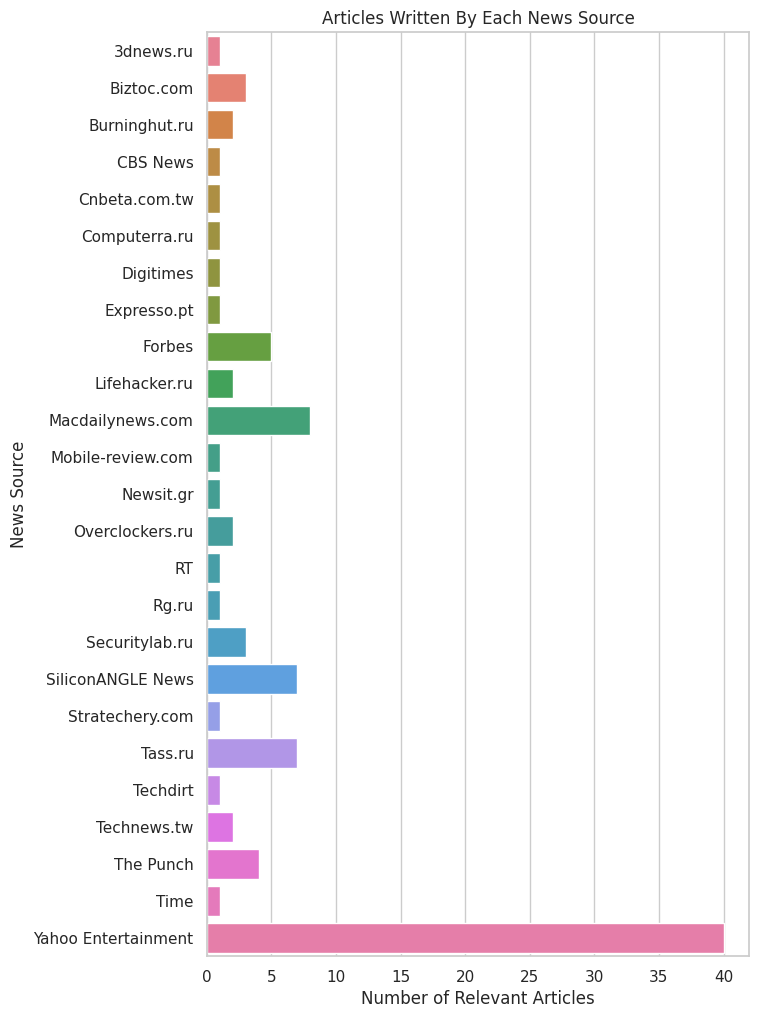

In [40]:
# Plot the number of relevant news articles written by each source
plt.figure(figsize =(7,12))
sns.set(style = 'whitegrid')

sns.barplot( x = source_data['description'], y = source_data.index, palette='husl')
plt.xlabel('Number of Relevant Articles')
plt.ylabel('News Source')
plt.title('Articles Written By Each News Source')
plt.savefig('Articles_Written_By_Source.png')
plt.show()

In [41]:
# Create a dataframe with news article unique dates
news_df['description'][pd.isnull(news_df['description']) == True]
date_data = pd.DataFrame(news_df.groupby('date').count())
date_data.reset_index(inplace=True)
date_data.head()

,date,author,title,description,url,image_url,content,source_id,source_name
0,1970-01-01,0,2,2,2,0,2,0,2
1,2024-07-01,2,2,2,2,2,2,0,2
2,2024-07-02,5,6,6,6,6,6,1,6
3,2024-07-03,2,3,3,3,2,3,0,3
4,2024-07-04,5,5,5,5,5,5,0,5


In [42]:
# Remove rows with the default date value "1970-01-01"
date_data['date'] = pd.to_datetime(date_data['date'])
date_data = date_data[date_data.loc[:, 'date'].dt.year != 1970]
date_data.set_index('date', inplace=True)
date_data.head()

,author,title,description,url,image_url,content,source_id,source_name
date,,,,,,,,
2024-07-01,2,2,2,2,2,2,0,2
2024-07-02,5,6,6,6,6,6,1,6
2024-07-03,2,3,3,3,2,3,0,3
2024-07-04,5,5,5,5,5,5,0,5
2024-07-05,3,4,4,4,4,4,0,4


<ipython-input-43-f83de2f17be8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  articles_time_plot = sns.barplot( x = date_data.index , y = date_data['description'], palette='hls')


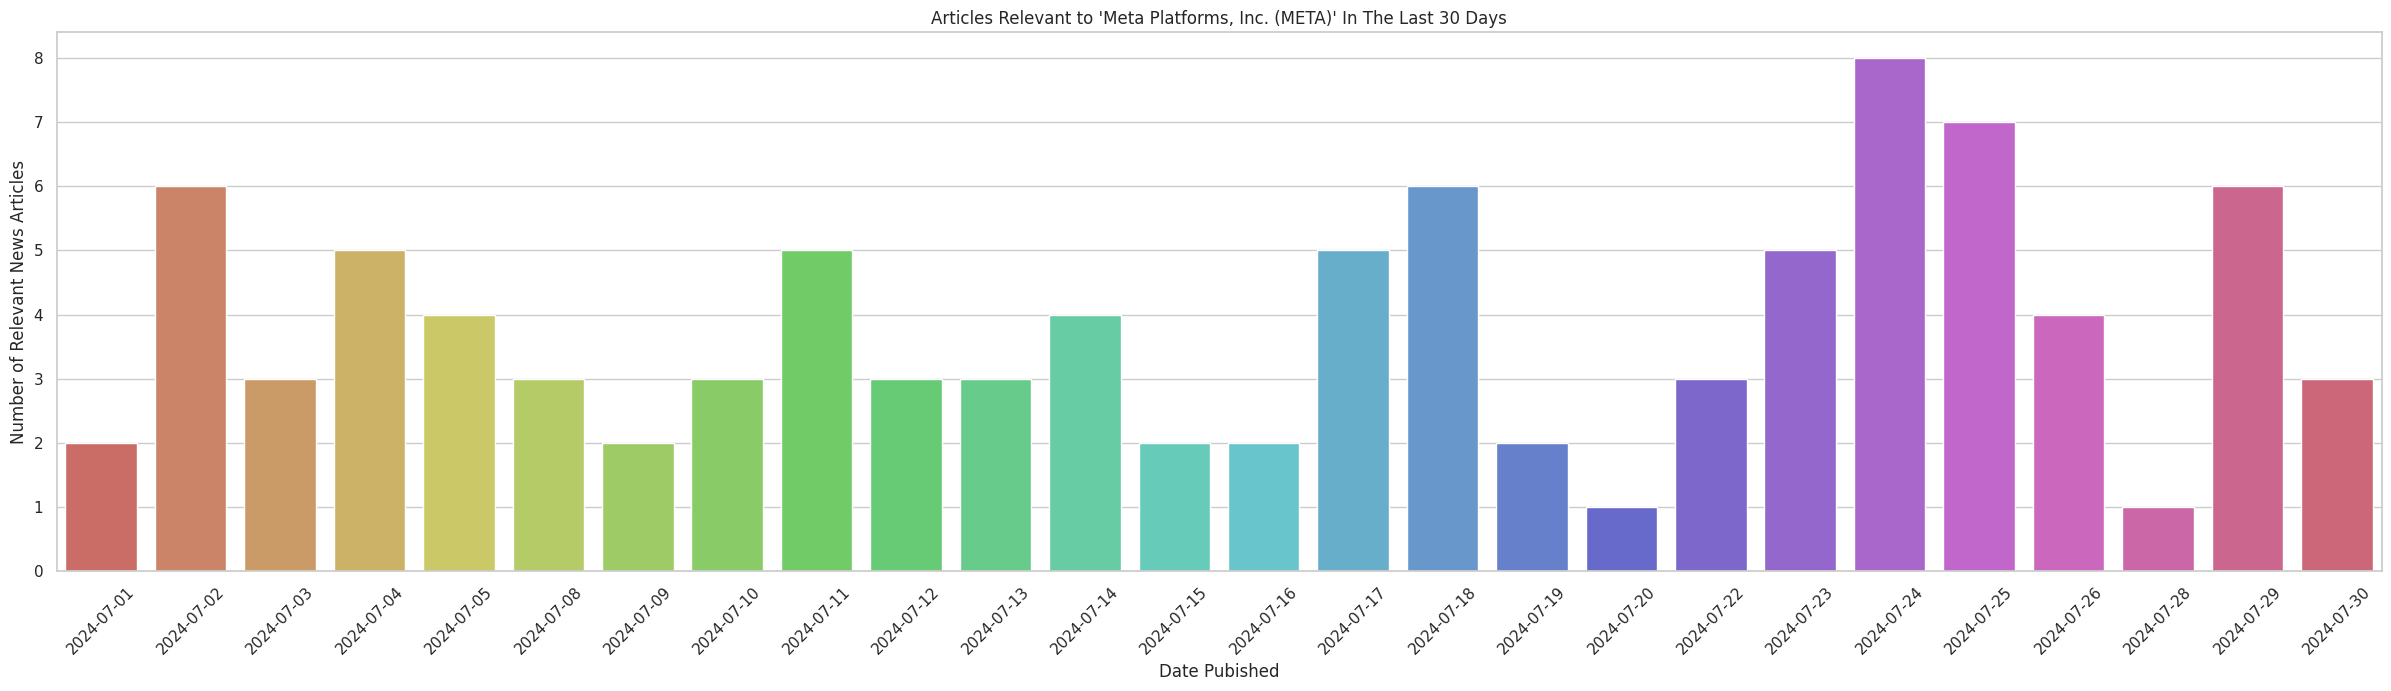

In [43]:
# Plot the number of news articles relevant to company in the past month
plt.figure(figsize =(30,7))
articles_time_plot = sns.barplot( x = date_data.index , y = date_data['description'], palette='hls')

# Set titles and labels
articles_time_plot.set(xlabel = 'Date Pubished', ylabel = 'Number of Relevant News Articles')
plt.xticks(rotation=45)
plt.title(f"Articles Relevant to '{company_name} ({ticker_symbol})' In The Last 30 Days")

plt.savefig('Articles_30_Days.png')
plt.show()

In [44]:
# Retrieve article description headers
news_df['description']= news_df['description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
news_df = news_df[news_df['description'] != '[removed]']
news_df = news_df[news_df['description'] != 'none']
news_df = news_df[news_df['description'] != '']
news_df.head()

,author,title,description,url,image_url,date,content,source_id,source_name
87,Maria Deutscher,EU probe tentatively finds that Meta breached ...,european union officials have tentatively dete...,https://siliconangle.com/2024/07/01/eu-probe-t...,https://d15shllkswkct0.cloudfront.net/wp-conte...,2024-07-01,European Union officials have tentatively dete...,None,SiliconANGLE News
31,Samuel Stolton,"Meta Hit by EU Warning Over Ad-Free Instagram,...",(bloomberg) -- meta platforms inc. has been sl...,https://finance.yahoo.com/news/meta-hit-eu-war...,https://s.yimg.com/ny/api/res/1.2/ceNWeA15CaTp...,2024-07-01,(Bloomberg) -- Meta Platforms Inc. has been sl...,None,Yahoo Entertainment
75,ТАСС,"Шунин рассказал, что мечтал еще поиграть за ""Д...",ранее в клубе сообщили об уходе вратаря,https://tass.ru/sport/21254987,https://cdn-storage-media.tass.ru/thumb/ru/spo...,2024-07-02,", 2 . //. """" -. Instagram ( ; Meta, ).\r\n1 """"...",None,Tass.ru
73,MacDailyNews,Apple shares hit new all-time intraday and clo...,"in nasdaq trading today, shares of apple inc. ...",https://macdailynews.com/2024/07/02/apple-shar...,https://149359564.v2.pressablecdn.com/wp-conte...,2024-07-02,"In Nasdaq trading today, shares of Apple Inc. ...",None,Macdailynews.com
15,Soumya Eswaran,Here’s Why Meta Platforms (META) Surged in Q1,"diamond hill capital, an investment management...",https://finance.yahoo.com/news/why-meta-platfo...,https://media.zenfs.com/en/insidermonkey.com/e...,2024-07-02,"Diamond Hill Capital, an investment management...",None,Yahoo Entertainment


In [45]:
# Retrieve word count for each description header
news_df['word_count'] = news_df['description'].apply(lambda x: len(str(x).split(" ")))
news_df[['description','word_count']].head()

,description,word_count
87,european union officials have tentatively dete...,36
31,(bloomberg) -- meta platforms inc. has been sl...,23
75,ранее в клубе сообщили об уходе вратаря,7
73,"in nasdaq trading today, shares of apple inc. ...",39
15,"diamond hill capital, an investment management...",22


In [46]:
# Call stopwords function to ignore words such as "the"," "an," "as," "a," etc.
stop = stopwords.words('english')
news_df['stopwords'] = news_df['description'].apply(lambda x: len([x for x in x.split() if x in stop]))
news_df[['description','stopwords']].head()

,description,stopwords
87,european union officials have tentatively dete...,9
31,(bloomberg) -- meta platforms inc. has been sl...,9
75,ранее в клубе сообщили об уходе вратаря,0
73,"in nasdaq trading today, shares of apple inc. ...",8
15,"diamond hill capital, an investment management...",6


In [47]:
# Show rows with numerical values
news_df['description'] = news_df['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
news_df['numerics'] = news_df['description'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
news_df['numerics'].head()

,numerics
87,0
31,0
75,0
73,0
15,1


In [48]:
# Convert to lowercase, expand contractions, and remove special characters, extra spaces, and non-ASCII characters
def remove_non_A(s):
    return "".join(i for i in s if ord(i) < 128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

In [49]:
# Create a dataframe with the dates for each unique description
description_df = news_df[['description','date']]
description_df.loc[:, 'description'] = description_df['description'].apply(remove_non_A)
description_df.head()

,description,date
87,european union officials tentatively determine...,2024-07-01
31,(bloomberg) -- meta platforms inc. slapped war...,2024-07-01
75,,2024-07-02
73,"nasdaq trading today, shares apple inc. rose h...",2024-07-02
15,"diamond hill capital, investment management co...",2024-07-02


In [63]:
# Initialize lexicon-based anaysis using Vader Sentiment Analyzer to determine the presence of positive, negative, and neutral sentiments
analyzer = SentimentIntensityAnalyzer()

# Create empty lists to store sentiment scores
positive_scores = []
negative_scores = []
neutral_scores = []
compound_scores = []

# Loop through each description and calculate sentiment scores
for description in description_df['description']:
    sentiment = analyzer.polarity_scores(description)
    positive_scores.append(sentiment['pos'])
    negative_scores.append(sentiment['neg'])
    neutral_scores.append(sentiment['neu'])
    compound_scores.append(sentiment['compound'])

description_df.loc[:, 'positive'] = positive_scores
description_df.loc[:, 'negative'] = negative_scores
description_df.loc[:, 'neutral'] = neutral_scores
description_df.loc[:, 'compound'] = compound_scores

# Sort DataFrame by 'date' column in ascending order
description_df.sort_values(by='date', ascending=True)

,description,date,positive,negative,neutral,compound
87,european union officials tentatively determine...,2024-07-01,0.135,0.000,0.865,0.4404
31,(bloomberg) -- meta platforms inc. slapped war...,2024-07-01,0.000,0.281,0.719,-0.5719
75,,2024-07-02,0.000,0.000,0.000,0.0000
73,"nasdaq trading today, shares apple inc. rose h...",2024-07-02,0.132,0.000,0.868,0.5267
15,"diamond hill capital, investment management co...",2024-07-02,0.138,0.000,0.862,0.3400
...,...,...,...,...,...,...
17,"overall, meta scheduled report fiscal q2 2024 ...",2024-07-29,0.000,0.000,1.000,0.0000
81,meta ?,2024-07-29,0.000,0.000,1.000,0.0000
98,meta platforms inc.s artificial intelligence r...,2024-07-30,0.185,0.000,0.815,0.7096
14,(bloomberg) -- advanced micro devices inc. gav...,2024-07-30,0.254,0.000,0.746,0.6249


## 2. Sentiment Analysis


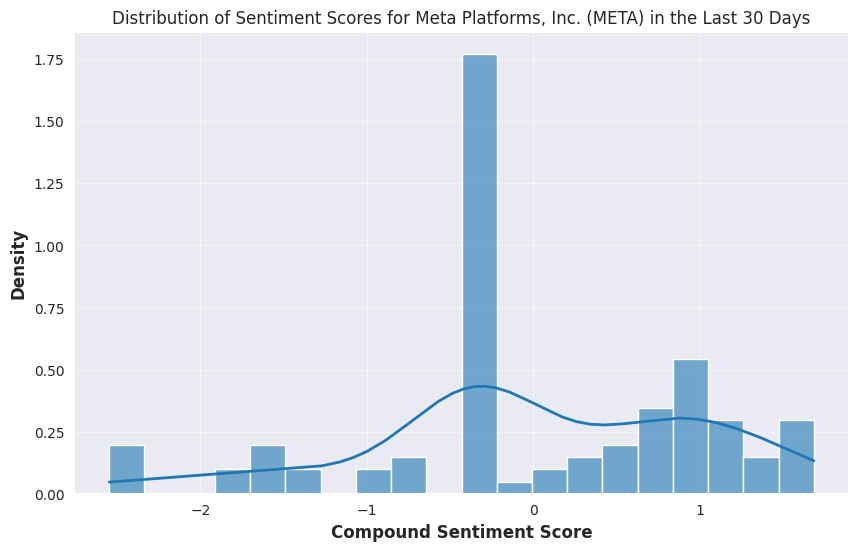

In [109]:
# @title Visualize Sentiment Scores and OHLC Data
# Visualize the distribution of sentiment scores within the past 30 days
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.histplot(description_df['compound'], bins=20, kde=True, stat='density', alpha=0.6)
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Density')
plt.title(f"Distribution of Sentiment Scores for {company_name} ({ticker_symbol}) in the Last 30 Days")

plt.show()

In [72]:
# Retrieve Open-High-Low-Close Data from Yahoo Finance with "Date" column indexed
stock_df = ticker.history(period="1mo")
stock_df.drop(['Dividends', 'Stock Splits', 'Volume'], axis=1, inplace=True)
stock_df.reset_index(inplace=True)
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df
stock_df.head()

,Date,Open,High,Low,Close
0,2024-07-01 00:00:00-04:00,504.950012,506.579987,493.170013,504.679993
1,2024-07-02 00:00:00-04:00,500.760010,510.500000,499.450012,509.500000
2,2024-07-03 00:00:00-04:00,506.369995,511.279999,506.019989,509.959991
3,2024-07-05 00:00:00-04:00,511.600006,540.869995,511.600006,539.909973
4,2024-07-08 00:00:00-04:00,542.349976,542.809998,526.650024,529.320007


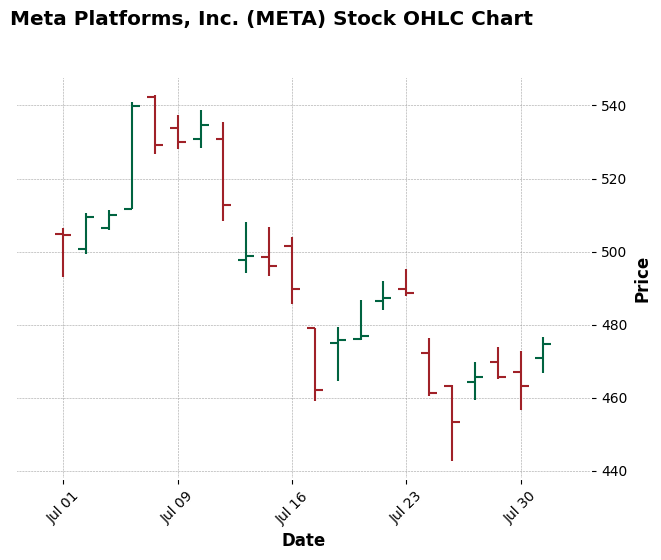

In [73]:
# Create an Open-High-Low-Close Chart
stock_df.set_index('Date', inplace=True)
stock_df.index = pd.to_datetime(stock_df.index)

ohlc_title = f"{company_name} ({ticker_symbol}) Stock OHLC Chart"
ohlc_chart = mpf.plot(stock_df, type = 'ohlc', style = 'charles', title = ohlc_title, xlabel = 'Date', ylabel = 'Price')

In [74]:
# Create a Dataframe with the "Close" and "Date" columns
close_df = pd.DataFrame(stock_df['Close'])
close_df.reset_index(inplace=True)
close_df['Date_Formatted'] = close_df['Date'].dt.strftime('%Y-%m-%d')
close_df

,Date,Close,Date_Formatted
0,2024-07-01 00:00:00-04:00,504.679993,2024-07-01
1,2024-07-02 00:00:00-04:00,509.500000,2024-07-02
2,2024-07-03 00:00:00-04:00,509.959991,2024-07-03
3,2024-07-05 00:00:00-04:00,539.909973,2024-07-05
4,2024-07-08 00:00:00-04:00,529.320007,2024-07-08
5,2024-07-09 00:00:00-04:00,530.000000,2024-07-09
6,2024-07-10 00:00:00-04:00,534.690002,2024-07-10
7,2024-07-11 00:00:00-04:00,512.700012,2024-07-11
8,2024-07-12 00:00:00-04:00,498.869995,2024-07-12
9,2024-07-15 00:00:00-04:00,496.160004,2024-07-15


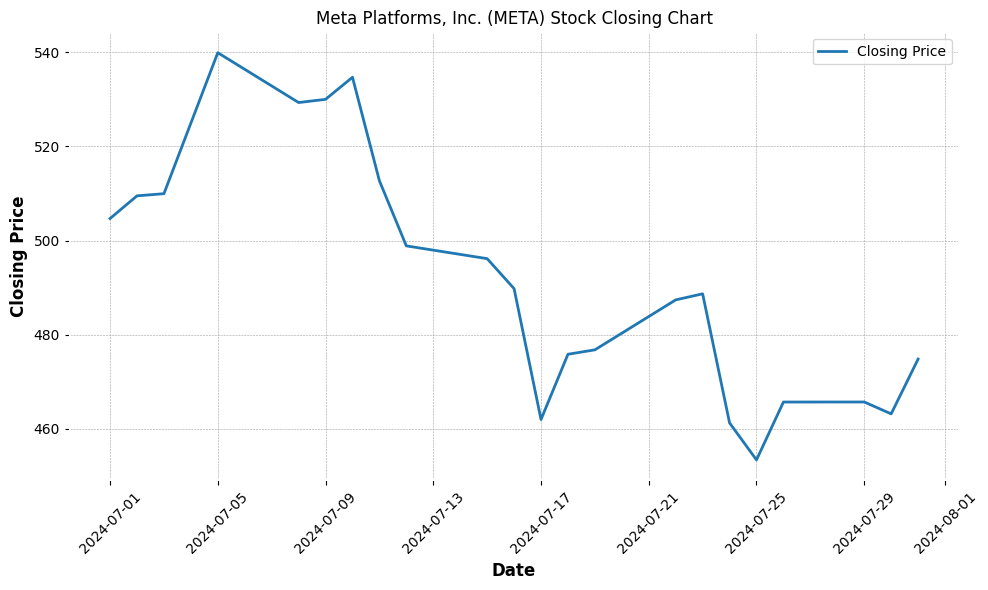

In [75]:
# Plot the closing price data
close_title = f"{company_name} ({ticker_symbol}) Stock Closing Chart"
plt.figure(figsize=(10, 6))
plt.plot(close_df['Date'], close_df['Close'], label='Closing Price')

# Set plot title and labels
plt.title(close_title)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

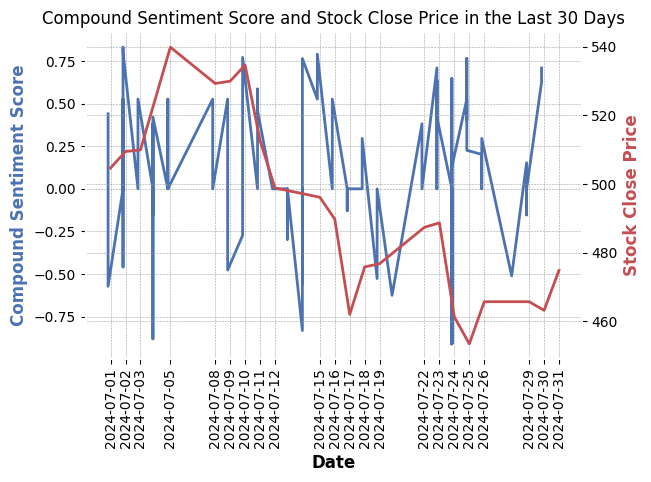

In [76]:
# Ensure columns are numeric and drop NaNs
close_df['Close'] = pd.to_numeric(close_df['Close'], errors='coerce')
description_df.loc[:, 'compound'] = pd.to_numeric(description_df['compound'], errors='coerce')
close_df = close_df.dropna(subset=['Close'])
description_df = description_df.dropna(subset=['compound'])

# Plot with dual y-axes
fig, axis_1 = plt.subplots()
axis_2 = axis_1.twinx()

# Create the "Compound Sentiment Score" y-axis data
description_df.plot(x='date', y="compound", ax = axis_1, legend=False, color='b')

# Create the "Stock Close Price" y-axis data
close_df.plot(x='Date', y="Close", ax = axis_2, legend=False, color='r')

# Rotate x-axis labels and set the x-ticks
axis_1.set_xticks(close_df['Date'])
axis_1.set_xticklabels(close_df['Date'].dt.strftime('%Y-%m-%d'), rotation=90)
axis_1.set_xlabel("Date")

# Set labels and titles
axis_1.set_ylabel("Compound Sentiment Score", color='b')
axis_2.set_ylabel("Stock Close Price", color='r')
plt.title("Compound Sentiment Score and Stock Close Price in the Last 30 Days")

# Show the plot
plt.xticks(rotation=45)
plt.show()

## 3. Feature Engineering

In [77]:
# @title Prepare Data for Prediction
# Normalize Close stock prices and compound sentiment scores
scaler_close = StandardScaler()
close_df['Close'] = scaler_close.fit_transform(close_df[['Close']])
scaler_compound = StandardScaler()
description_df['compound'] = scaler_compound.fit_transform(description_df[['compound']])

# Ensure dates are in datetime format
close_df['Date_Formatted'] = pd.to_datetime(close_df['Date_Formatted'])
description_df['date'] = pd.to_datetime(description_df['date'])

# Merge close_df and description_df
combined_df = pd.merge(close_df, description_df, left_on='Date_Formatted', right_on='date', how='inner')
combined_df.reset_index(drop=True, inplace=True)
combined_df['Date_Formatted'] = pd.to_datetime(combined_df['Date'], format='%Y-%m-%d')
combined_df.set_index('Date_Formatted', inplace=True)

print("DataFrame Columns:")
print(combined_df.columns)
combined_df.head()

DataFrame Columns:
Index(['Date', 'Close', 'description', 'date', 'positive', 'negative',
       'neutral', 'compound'],
      dtype='object')


,Date,Close,description,date,positive,negative,neutral,compound
Date_Formatted,,,,,,,,
2024-07-01 00:00:00-04:00,2024-07-01 00:00:00-04:00,0.480801,european union officials tentatively determine...,2024-07-01,0.135,0.000,0.865,0.733322
2024-07-01 00:00:00-04:00,2024-07-01 00:00:00-04:00,0.480801,(bloomberg) -- meta platforms inc. slapped war...,2024-07-01,0.000,0.281,0.719,-1.726453
2024-07-02 00:00:00-04:00,2024-07-02 00:00:00-04:00,0.667864,,2024-07-02,0.000,0.000,0.000,-0.336800
2024-07-02 00:00:00-04:00,2024-07-02 00:00:00-04:00,0.667864,"nasdaq trading today, shares apple inc. rose h...",2024-07-02,0.132,0.000,0.868,0.943022
2024-07-02 00:00:00-04:00,2024-07-02 00:00:00-04:00,0.667864,"diamond hill capital, investment management co...",2024-07-02,0.138,0.000,0.862,0.489362


## 4. Model Development and Evaluation

In [86]:
# @title Stock Trend Prediction using Long Short Term Memory (LSTM)
# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_df[['compound', 'Close']])

# Create sequences
def create_sequences(df, seq_length):
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df[i:i + seq_length, :])  # Features
        y.append(df[i + seq_length, 1])  # Target
    return np.array(X), np.array(y)

SEQ_LENGTH = 20
X, y = create_sequences(scaled_features, SEQ_LENGTH)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build the LSTM Model and callbacks
model = Sequential()
model.add(Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.3, kernel_regularizer='l2'), input_shape=(SEQ_LENGTH, X.shape[2])))
model.add(Bidirectional(LSTM(units=100, dropout=0.3, kernel_regularizer='l2')))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[early_stopping, model_checkpoint], verbose=1)

# Evaluate the model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 5.9825 - val_loss: 5.9347
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - loss: 5.5324 - val_loss: 5.2571
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - loss: 5.2207 - val_loss: 4.8968
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - loss: 4.9028 - val_loss: 4.5928
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 4.6582 - val_loss: 4.3053
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 4.3658 - val_loss: 4.0376
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 4.2499 - val_loss: 3.8280
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 3.9249 - val_loss: 3.6468
Epoch 9/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 3.6662 - val_loss: 3.4812
Epoch 10/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 3.4984 - val_loss: 3.3182
Epoch 11/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 3.3154 - val_loss: 3.1508
Epoch 12/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 3.1941 - val_loss: 2.9759
Ep

In [87]:
# Calculate MSE and RMSE for Training Data
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)

# Calculate MSE and RMSE for Testing Data
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)

print(f"Training MSE: {train_mse:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Training MSE: 0.1114
Training RMSE: 0.3338
Test MSE: 0.1135
Test RMSE: 0.3369


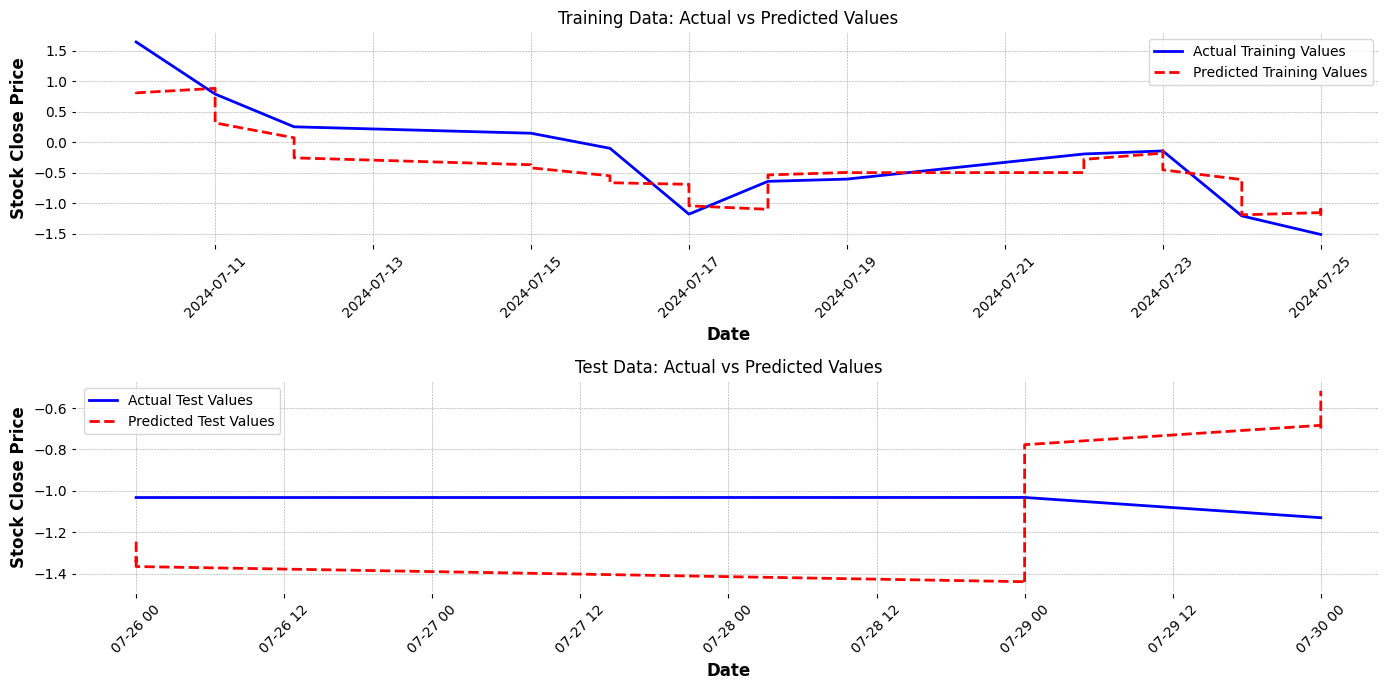

In [88]:
# Reshape y_train and y_test
y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

# Inverse transform the actual values and predictions
scaler_close = StandardScaler().fit(combined_df[['Close']])
y_train_original = scaler_close.inverse_transform(y_train_reshaped)
y_test_original = scaler_close.inverse_transform(y_test_reshaped)
train_predictions_original = scaler_close.inverse_transform(train_predictions)
test_predictions_original = scaler_close.inverse_transform(test_predictions)

# Extract dates
train_dates = combined_df.index[SEQ_LENGTH:SEQ_LENGTH + len(y_train)]
test_dates = combined_df.index[len(y_train) + SEQ_LENGTH:len(y_train) + SEQ_LENGTH + len(y_test)]

# Plot results
plt.figure(figsize=(14, 7))

# Plot Training Data
plt.subplot(2, 1, 1)
plt.plot(train_dates, y_train_original, label='Actual Training Values', color='blue')
plt.plot(train_dates, train_predictions_original, label='Predicted Training Values', color='red', linestyle='--')
plt.title('Training Data: Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Stock Close Price')
plt.legend()
plt.xticks(rotation=45)

# Plot Test Data
plt.subplot(2, 1, 2)
plt.plot(test_dates, y_test_original, label='Actual Test Values', color='blue')
plt.plot(test_dates, test_predictions_original, label='Predicted Test Values', color='red', linestyle='--')
plt.title('Test Data: Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Stock Close Price')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [89]:
# Determine mean MSE through K-Fold Cross Validation
tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    predictions = model.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, predictions))

mean_mse = np.mean(mse_scores)
print(f"Mean MSE from TimeSeriesSplit: {mean_mse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Mean MSE from TimeSeriesSplit: 0.32252890916553223


In [94]:
# @title Stock Trend Prediction using Autoregressive Integrated Moving Average (ARIMA)
combined_df[['compound', 'Close']] = scaler.fit_transform(combined_df[['compound', 'Close']])

# # Create a composite feature by adding 'compound' and 'Close'
combined_df['Composite'] = combined_df['compound'] + combined_df['Close']

# Train and test sets
train_size = int(len(combined_df) * 0.8)
train_series = combined_df['Composite'][:train_size]
test_series = combined_df['Composite'][train_size:]

# Find the best ARIMA parameters
model_auto = auto_arima(train_series, seasonal=False, trace=True,
                        error_action='ignore', suppress_warnings=True,
                        stepwise=True)
print(model_auto.summary())

# Fit and test ARIMA model
best_order = model_auto.order
model = ARIMA(train_series, order=best_order)
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test_series))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=240.440, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=232.319, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=219.771, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=238.468, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=220.663, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=218.092, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=219.744, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=219.546, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=230.343, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=219.292, Time=1.35 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 6.929 seconds
                               SARIMAX Results 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [95]:
# Evaluate the model
mse = mean_squared_error(test_series, forecast)
test_rmse = np.sqrt(mse)
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Test MSE: 0.5629
Test RMSE: 0.7503


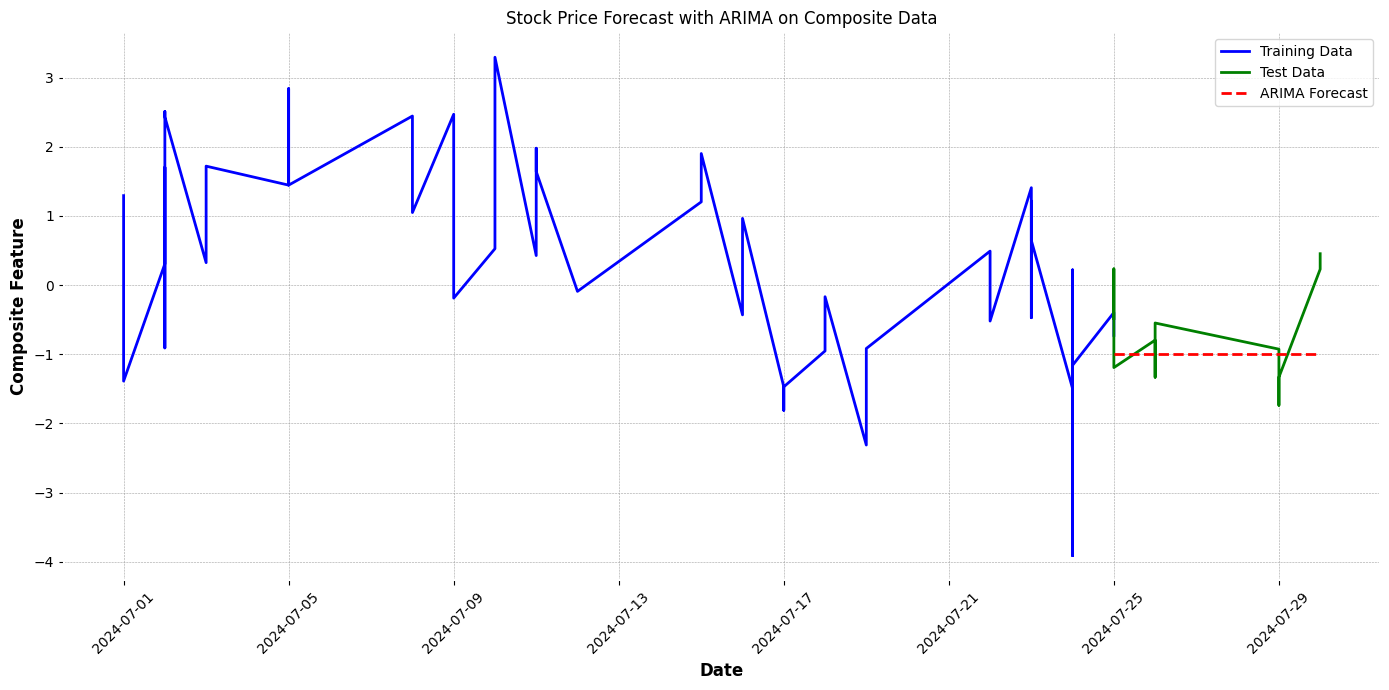

In [102]:
# Plot results
plt.figure(figsize=(14, 7))

plt.plot(train_series.index, train_series, label='Training Data', color='blue')
plt.plot(test_series.index, test_series, label='Test Data', color='green')
plt.plot(test_series.index, forecast, label='ARIMA Forecast', color='red', linestyle='--')

plt.title('Stock Price Forecast with ARIMA on Composite Data')
plt.xlabel('Date')
plt.ylabel('Composite Feature')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [103]:
# @title Stock Trend Prediction using Linear Regression
# Prepare the features and target, and drop rows with NaN values
combined_df['Target'] = combined_df['Close'].shift(-1)  # Shift Close column to create a target for the next day
data = combined_df.dropna(subset=['Target'])

# Features and target
X = data[['compound', 'Close']]
y = data['Target']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

In [104]:
# Evaluate the model
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)

print(f"Training MSE: {train_mse:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Training MSE: 0.0766
Training RMSE: 0.2767
Test MSE: 0.0163
Test RMSE: 0.1275


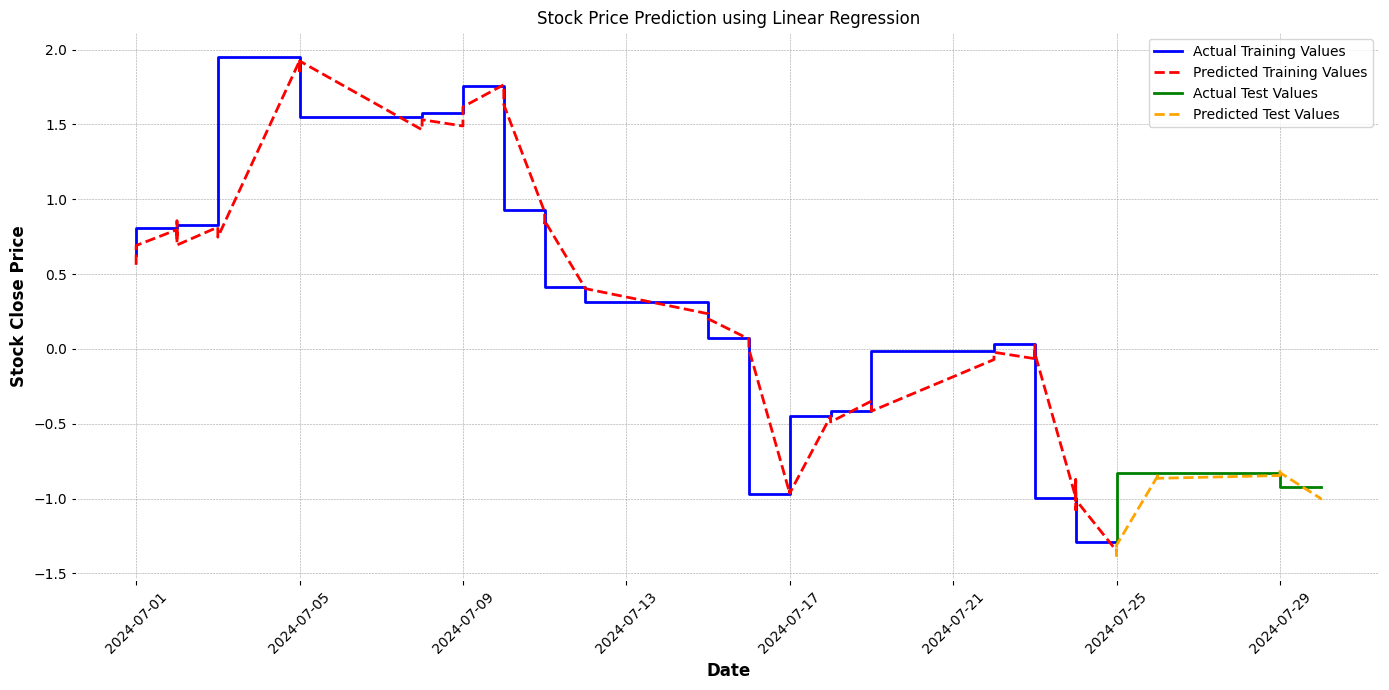

In [105]:
# Plot results
plt.figure(figsize=(14, 7))

plt.plot(y_train.index, y_train, label='Actual Training Values', color='blue')
plt.plot(y_train.index, train_predictions, label='Predicted Training Values', color='red', linestyle='--')

plt.plot(y_test.index, y_test, label='Actual Test Values', color='green')
plt.plot(y_test.index, test_predictions, label='Predicted Test Values', color='orange', linestyle='--')

plt.title('Stock Price Prediction using Linear Regression')
plt.xlabel('Date')
plt.ylabel('Stock Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()